# Feature Selection

## Remove Correlated Variables

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('team_batter_revised.csv')

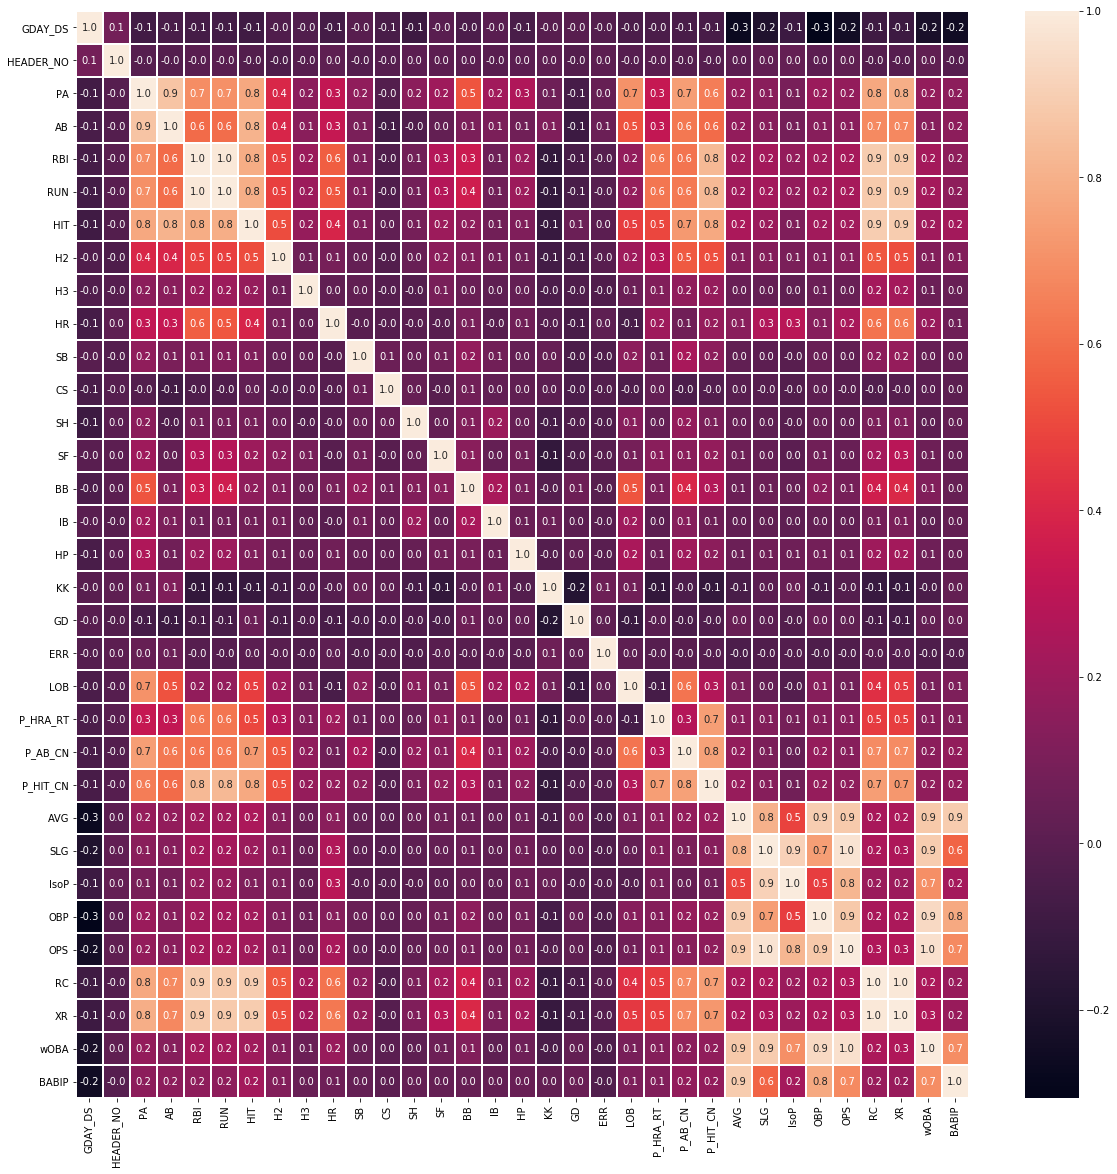

In [3]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidth=1)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

**Variable Selection Criteria**
1. 상관계수 0.9 이상 변수
2. 기존변수 vs. 파생변수 $\rightarrow$ 기존변수
3. 기존변수 vs. 기존변수 or 파생변수 vs. 파생변수 $\rightarrow$ 주관적 판단

**High-Correlated Variables**
1. PA(타자수) vs. AB(타수) $\rightarrow$ 보류
2. AVG(타율) vs. SLG(장타율), OBP(출루율), OPS(장타율+출루율), wOBA(가중출루율), BABIP $\rightarrow$ AVG(타율)만 보존
3. IsoP(순장타율) 보존
4. RC(득점기여도) vs. XR(득점공헌도) $\rightarrow$ XR(득점공헌도) 제거

In [5]:
data = data.drop(['PA', 'AB', 'RBI', 'RUN', 'HIT', 'SLG', 'OBP', 'OPS', 'XR', 'wOBA', 'BABIP'], axis=1)

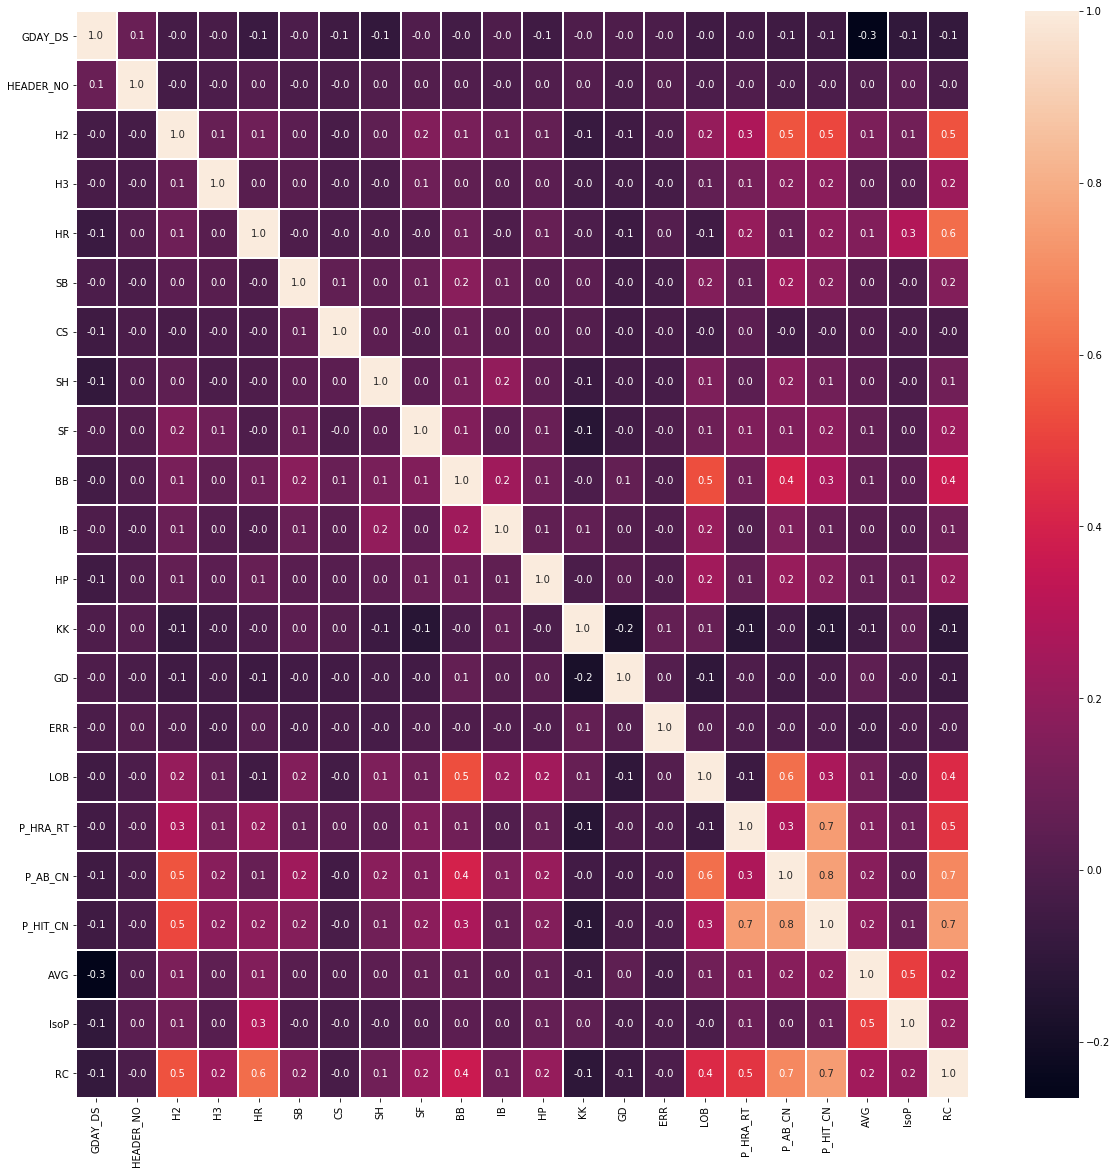

In [6]:
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(data.corr(), annot=True, fmt='.1f', linewidth=1)

## Preparation for Lasso

**Remove Draw Data**

In [7]:
data = data.loc[data['WLS']!='D',].reset_index(drop=True)

**Remove Variables**

In [8]:
G_DAYS = data['GDAY_DS']
T_ID = data['T_ID']
VS_T_ID = data['VS_T_ID']
WLS = data['WLS']
data = data.drop(['G_ID','GDAY_DS', 'T_ID','VS_T_ID'], axis=1)

In [9]:
WLS=(WLS=='W')*1

**Dummy Variables**

T_ID, VS_T_ID, HEADER_NO, TB_SC 더미변수로 변환

In [10]:
'''data = pd.concat([data, pd.get_dummies(data['T_ID'], prefix='T_ID', drop_first=True)], axis=1)
data = pd.concat([data, pd.get_dummies(data['VS_T_ID'], prefix='VS_T_ID', drop_first=True)], axis=1)'''
data = pd.concat([data, pd.get_dummies(data['HEADER_NO'], prefix='HEADER_NO', drop_first=True)], axis=1)
data = pd.concat([data, pd.get_dummies(data['TB_SC'], prefix='TB_SC', drop_first=True)], axis=1)
data = data.drop(['HEADER_NO', 'TB_SC'], axis=1)

**Min-Max Scaling**

나머지 변수들 Min-Max 스케일링

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(data[['H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF', 'BB', 'IB', 'HP', 'KK',
       'GD', 'ERR', 'LOB', 'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN', 'AVG', 'IsoP', 'RC']])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
data.iloc[:,:20] = scaler.transform(data[['H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF', 'BB', 'IB', 'HP', 'KK',
       'GD', 'ERR', 'LOB', 'P_HRA_RT', 'P_AB_CN', 'P_HIT_CN', 'AVG', 'IsoP', 'RC']])

## Merge with Pitcher Data

In [15]:
data = data.rename({'GD':'HIT_GD', 'KK':'HIT_KK', 'HP':'HIT_HP', 'IB':'HIT_IB', 'BB':'HIT_BB', 'SF':'HIT_SF', 'SH':'HIT_SH',
                   'CS':'HIT_CS', 'SB':'HIT_SB', 'HR':'HIT_HR', 'H3':'HIT_H3', 'H2':'HIT_H2'}, axis=1)

In [16]:
data1 = pd.read_csv('team_pitcher_revised.csv')

In [17]:
data2 = pd.concat([data, data1], axis=1)

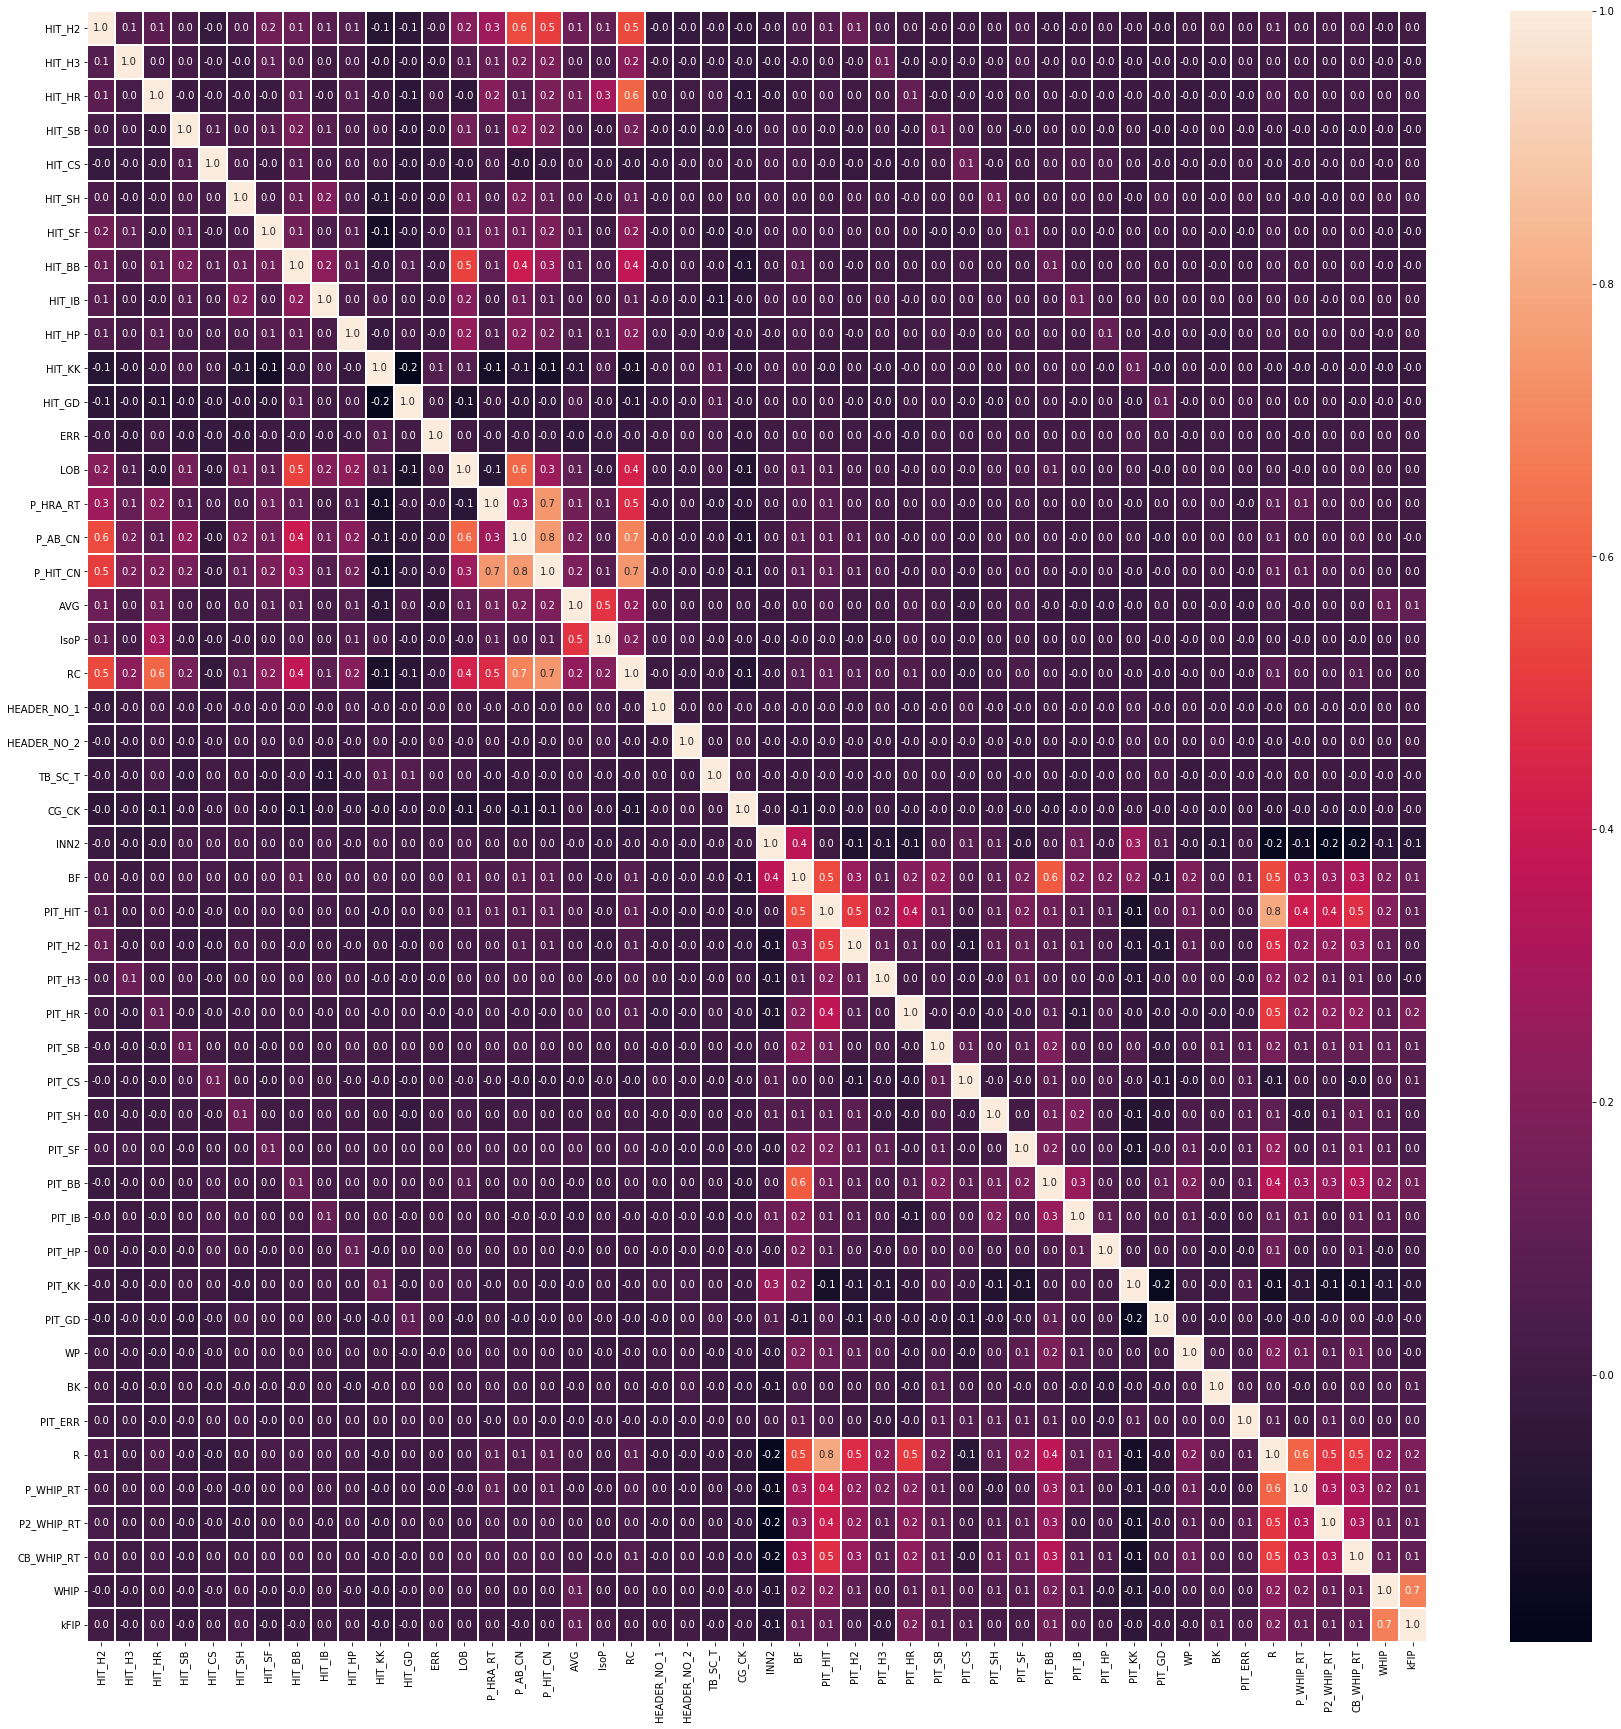

In [18]:
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(data2.corr(), annot=True, fmt='.1f', linewidth=1)

## Variable Importance with RandomForest

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = data2.drop(['WLS'], axis=1)
y = data2['WLS']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf = RandomForestClassifier(random_state=0)

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
rf.score(X_train, y_train)

1.0

In [26]:
rf.score(X_test, y_test)

0.5384983261597321

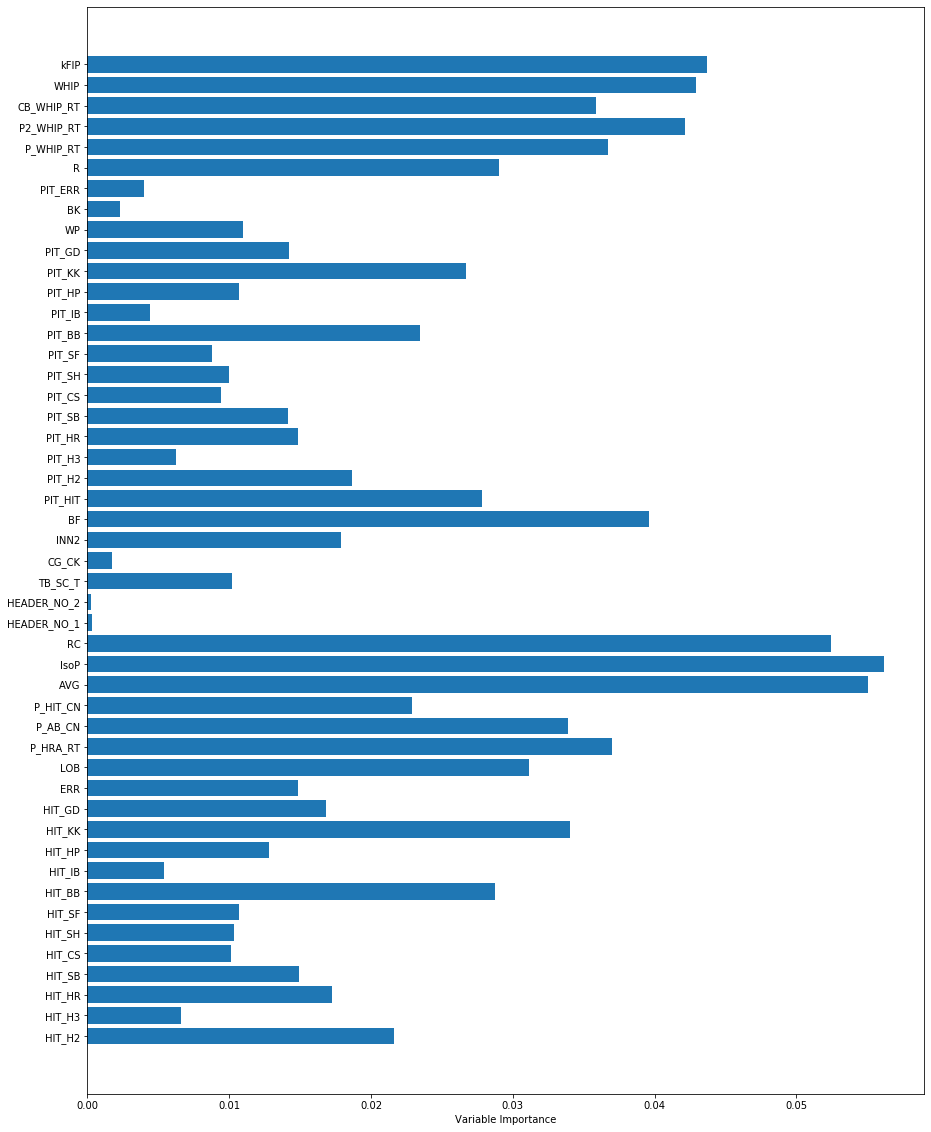

In [27]:
fig, ax = plt.subplots(figsize=(15, 20))
ax.barh(X_test.columns, rf.feature_importances_)
ax.set_xlabel('Variable Importance')
plt.show()

In [28]:
feature_importance = pd.DataFrame(rf.feature_importances_, X_test.columns)

In [29]:
feature = feature_importance[feature_importance[0]>0.01].index
feature = feature.to_list()
feature.append('WLS')

# 승률예측모형

In [30]:
data2 = data2[feature]
data2['GDAY_DS'] = G_DAYS
data2['T_ID'] = T_ID
data2['VS_T_ID'] = VS_T_ID

In [31]:
data2

,HIT_H2,HIT_HR,HIT_SB,HIT_CS,HIT_SH,HIT_SF,HIT_BB,HIT_HP,HIT_KK,HIT_GD,...,R,P_WHIP_RT,P2_WHIP_RT,CB_WHIP_RT,WHIP,kFIP,WLS,GDAY_DS,T_ID,VS_T_ID
0,0.222222,0.000,0.000000,0.00,0.6,0.0,0.230769,0.0,0.555556,0.2,...,0.173913,0.035714,0.061224,0.200000,0.600000,0.112353,W,20160401,HH,LG
1,0.222222,0.125,0.285714,0.25,0.2,0.0,0.307692,0.0,0.611111,0.0,...,0.217391,0.083333,0.047619,0.062500,0.488235,0.295889,L,20160401,LG,HH
2,0.333333,0.125,0.000000,0.00,0.0,0.0,0.230769,0.2,0.555556,0.2,...,0.173913,0.074074,0.049451,0.178571,0.533333,0.355149,W,20160401,HT,NC
3,0.222222,0.250,0.000000,0.00,0.2,0.0,0.384615,0.0,0.500000,0.2,...,0.217391,0.027778,0.080745,0.156250,0.850000,0.677669,L,20160401,NC,HT
4,0.555556,0.125,0.000000,0.00,0.0,0.0,0.000000,0.0,0.388889,0.2,...,0.347826,0.055556,0.112245,0.187500,0.800000,0.645054,L,20160401,SK,KT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,0.111111,0.125,0.000000,0.00,0.2,0.0,0.076923,0.0,0.388889,0.6,...,0.304348,0.055556,0.081633,0.500000,0.619083,0.349670,W,20200719,LT,SS
6330,0.000000,0.000,0.000000,0.00,0.0,0.0,0.461538,0.0,0.277778,0.2,...,0.130435,0.133333,0.052910,0.083333,0.750171,0.479200,L,20200719,HT,OB
6331,0.333333,0.125,0.285714,0.25,0.0,0.0,0.153846,0.4,0.222222,0.0,...,0.043478,0.047619,0.063492,0.125000,0.655788,0.349297,W,20200719,OB,HT
6332,0.000000,0.000,0.000000,0.00,0.0,0.0,0.538462,0.0,0.555556,0.0,...,0.130435,0.000000,0.047619,0.125000,0.762397,0.466537,W,20200719,SK,WO


In [32]:
cols = data2.columns.tolist()
cols = cols[-3:] + cols[:-3]
data2 = data2[cols]
data2['WLS'] = pd.get_dummies(data2['WLS'])['W']

In [33]:
import numpy as np
G_DAYS = G_DAYS.astype(str)

In [34]:
pd.options.display.max_rows = 100

In [35]:
'''
idx_2016 = np.where(G_DAYS.str.slice(0,4)=='2016')
df_2016 = data2.iloc[idx_2016]
WIN = df_2016.groupby(['T_ID','VS_T_ID'])['WLS'].sum()
LEN = df_2016.groupby(['T_ID','VS_T_ID'])['WLS'].count()
WL = WIN/LEN
WL = WL.to_frame(name="odds")
WL.reset_index(inplace=True)

idx_2017 = np.where(G_DAYS.str.slice(0,4)=='2017')
df_2017 = data2.iloc[idx_2017]
df_2017[(df_2017['T_ID']=='OB')&(df_2017['VS_T_ID']=='HH')]['WLS'].values
'''

'\nidx_2016 = np.where(G_DAYS.str.slice(0,4)==\'2016\')\ndf_2016 = data2.iloc[idx_2016]\nWIN = df_2016.groupby([\'T_ID\',\'VS_T_ID\'])[\'WLS\'].sum()\nLEN = df_2016.groupby([\'T_ID\',\'VS_T_ID\'])[\'WLS\'].count()\nWL = WIN/LEN\nWL = WL.to_frame(name="odds")\nWL.reset_index(inplace=True)\n\nidx_2017 = np.where(G_DAYS.str.slice(0,4)==\'2017\')\ndf_2017 = data2.iloc[idx_2017]\ndf_2017[(df_2017[\'T_ID\']==\'OB\')&(df_2017[\'VS_T_ID\']==\'HH\')][\'WLS\'].values\n'

In [36]:
data2.to_csv('scaling.csv', index=False)

In [37]:
df_fac = data2.drop(['GDAY_DS','T_ID','VS_T_ID'],axis=1)

# Factor Analysis

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [39]:
# 타자 투수 합쳤을 때는 58%, 타자 투수 나누는게 46%

## Choosing the Number of Factors

In [40]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.analyze(df_fac, 10, rotation=None)
ev, v = fa.get_eigenvalues()
# ev

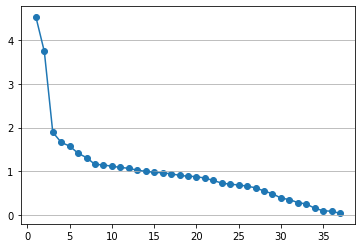

In [41]:
plt.scatter(range(1, df_fac.shape[1]+1),ev)
plt.plot(range(1,df_fac.shape[1]+1),ev)
plt.grid(axis='y')
plt.show() #Factor가 12개

In [42]:
fa = FactorAnalyzer()
fa.analyze(df_fac, 12, rotation="varimax")
#각 loading 값들이 최대한 서로 다르게 하기위해 Varimax rotation 실행.#fa.loadings
#fa.loadings
# fa.loadgins=L이며 L은 factor간 선형결합의 weight를 의미함. L 추정 중요
loadings = fa.loadings.copy()
loadings = loadings.apply(lambda x: np.where(x==max(x)), axis=1)
loadings = loadings.apply(lambda x: int(sum(x)))
loadings = loadings.to_dict()
fac = {n:[k for k in loadings.keys() if loadings[k] == n] for n in set(loadings.values())}
for i in range(len(fac.keys())):
    fac['Factor'+str(i+1)] = fac.pop(i)
fac

{'Factor1': ['PIT_HIT',
  'PIT_H2',
  'PIT_SB',
  'PIT_HP',
  'WP',
  'R',
  'P_WHIP_RT',
  'P2_WHIP_RT',
  'CB_WHIP_RT'],
 'Factor2': ['HIT_SB',
  'HIT_SH',
  'HIT_SF',
  'HIT_BB',
  'HIT_HP',
  'LOB',
  'P_AB_CN',
  'RC'],
 'Factor3': ['HIT_CS', 'INN2', 'BF', 'PIT_KK', 'WLS'],
 'Factor4': ['WHIP', 'kFIP'],
 'Factor5': ['HIT_HR'],
 'Factor6': ['P_HRA_RT', 'P_HIT_CN'],
 'Factor7': ['HIT_KK', 'ERR', 'TB_SC_T'],
 'Factor8': ['PIT_HR'],
 'Factor9': ['AVG', 'IsoP'],
 'Factor10': ['PIT_BB'],
 'Factor11': ['HIT_GD', 'PIT_GD'],
 'Factor12': ['HIT_H2']}

In [43]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12
SS Loadings,3.541372,2.475608,1.232661,1.498544,1.275585,2.032687,1.078135,1.009671,1.142349,0.870416,0.585750,0.683536
Proportion Var,0.095713,0.066908,0.033315,0.040501,0.034475,0.054937,0.029139,0.027288,0.030874,0.023525,0.015831,0.018474
Cumulative Var,0.095713,0.162621,0.195936,0.236437,0.270913,0.325850,0.354989,0.382277,0.413152,0.436676,0.452508,0.470981


In [44]:
X = df_fac.values
fa = FactorAnalysis(n_components=12)
X_fa = fa.fit_transform(X)
df_fa = pd.DataFrame(data=X_fa)

In [45]:
df_fa['T_ID'] = T_ID
df_fa['VS_T_ID'] = VS_T_ID
df_fa['GDAY_DS'] = G_DAYS
df_fa['WLS'] = WLS

In [46]:
cols = df_fa.columns.tolist()
cols = cols[-4:] + cols[:-4]
df_fa = df_fa[cols]
df_fa

,T_ID,VS_T_ID,GDAY_DS,WLS,0,1,2,3,4,5,6,7,8,9,10,11
0,HH,LG,20160401,1,0.192676,0.091628,-1.432495,1.679426,0.499260,3.894372,-0.054326,0.036209,1.014059,-0.413728,1.278939,0.095778
1,LG,HH,20160401,0,0.219358,0.086341,-0.953133,0.052901,1.727799,2.952906,0.749410,-0.673073,0.714847,-2.360676,0.740970,-0.359671
2,HT,NC,20160401,1,-0.527328,-0.522586,0.252851,0.667008,-0.277221,1.296001,1.245561,-1.200429,-0.151753,-0.148548,-0.090824,-0.424188
3,NC,HT,20160401,0,-0.208435,-0.063096,1.533768,0.451266,0.094279,-2.757778,-1.479059,-0.426554,-2.137658,0.576359,-0.376195,0.552376
4,SK,KT,20160401,0,-0.057048,0.460493,-0.042982,-1.108011,-0.121140,-2.005066,-1.222848,-0.986454,-1.377836,-0.177402,-0.828890,0.417127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,LT,SS,20200719,1,-1.400816,0.641598,0.740884,-0.942801,-0.885065,1.226125,0.506928,-1.051404,0.334419,0.905783,0.046403,1.381643
6330,HT,OB,20200719,0,-0.077664,-0.795475,-1.138613,-1.157809,1.104806,-1.291388,0.201617,1.617764,-0.331740,-0.435821,0.002509,-0.591646
6331,OB,HT,20200719,1,0.372625,-1.076195,-0.351830,-0.652056,-0.136101,0.660528,0.016753,-0.479919,-0.458328,0.862679,0.434435,0.555789
6332,SK,WO,20200719,1,-0.630949,-0.690365,-0.806038,0.301130,-0.138779,-0.800006,-0.322622,1.004945,0.614965,-1.332643,0.359427,0.843785


In [47]:
df_fa = df_fa.sort_values(by=['T_ID','VS_T_ID'],axis=0)

In [48]:
def update_odds(team):
    df = df_fa[df_fa['T_ID']==team].reset_index(drop=True)
    odds= []
    for enemy in list(df['VS_T_ID'].unique()):
        df_e = df[df['VS_T_ID']==enemy]
        k=1
        cum = []
        for i in list(df_e['WLS']):
            cum.append(i)
            odds.append(sum(cum)/k)
            k+=1
    df['update_odds'] = pd.Series(odds)
    return(df)

In [49]:
# 누적승률계산
new_df = pd.DataFrame()
for i in list(df_fa['T_ID'].unique()):
    new_df = pd.concat([new_df, update_odds(i)], axis=0)
new_df.reset_index(drop=True)

,T_ID,VS_T_ID,GDAY_DS,WLS,0,1,2,3,4,5,6,7,8,9,10,11,update_odds
0,HH,HT,20160426,1,-0.589597,-0.470352,0.218291,0.913810,1.052633,-1.219052,-1.539206,0.141899,1.331924,-0.504729,0.021673,-0.303719,1.000000
1,HH,HT,20160428,0,-0.348172,-0.176741,-0.696546,0.914726,1.110580,0.579886,-0.490614,1.886745,0.956128,-0.043061,-0.362149,-0.329867,0.500000
2,HH,HT,20160513,1,-1.099738,-0.811346,-0.367701,-0.385119,0.642424,-0.176176,0.149441,1.642859,0.478241,-0.044012,-0.427803,-0.346174,0.666667
3,HH,HT,20160514,0,-1.651826,0.671027,0.164516,-1.033010,-1.042827,-2.069932,-0.975873,-0.043853,1.340321,0.656468,-0.765742,-0.283461,0.500000
4,HH,HT,20160515,0,1.652573,0.822584,-1.790444,1.570901,-0.255997,1.174153,-0.854794,-0.331554,0.992371,0.811528,1.636434,0.699581,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6329,WO,SS,20200610,1,-1.115563,0.704868,-0.337572,-0.855383,0.167986,0.263304,0.399935,-0.104873,-0.591573,-0.065586,-0.428904,1.754064,0.594203
6330,WO,SS,20200611,1,-1.084838,0.750812,0.578688,0.631802,1.678345,-0.820957,0.649319,-0.517785,0.196174,0.825011,0.236145,-0.760303,0.600000
6331,WO,SS,20200707,0,-1.602974,-1.104376,0.148920,-0.385389,0.280287,1.140805,0.140162,-0.140354,-0.516653,-0.023861,-1.924263,0.451434,0.591549
6332,WO,SS,20200708,0,0.317406,-0.248736,0.905253,-0.570092,-0.618859,-0.330123,1.435891,1.302359,-0.586154,-1.245723,-0.298303,0.271771,0.583333


In [50]:
new_df.groupby(['T_ID','VS_T_ID']).mean()

WLS         0         1         2         3         4  \
T_ID VS_T_ID                                                               
HH   HT       0.521739 -0.213334  0.085625 -0.264304  0.048787  0.152101   
     KT       0.583333  0.201796  0.132881  0.005098 -0.185841  0.039033   
     LG       0.575342 -0.376663  0.121018 -0.273826 -0.029869 -0.101730   
     LT       0.547945 -0.136011  0.054692 -0.210979 -0.034633  0.015138   
     NC       0.394366 -0.079446  0.047409 -0.168614 -0.053357 -0.018779   
     OB       0.471429 -0.068086  0.010582 -0.147548  0.215090 -0.033360   
     SK       0.534247 -0.262700 -0.019406  0.046417 -0.000832 -0.101182   
     SS       0.338462 -0.036932  0.071302 -0.025646 -0.084776  0.132828   
     WO       0.585714 -0.011871  0.254779  0.020407 -0.222720 -0.066332   
HT   HH       0.478261 -0.087133  0.121021 -0.174493 -0.068397  0.049786   
     KT       0.493151  0.164105 -0.099424 -0.082608 -0.047106  0.047880   
     LG       0.393939 -0.030329 -0.106227 -0.105946 -0.158550 -0.106622   
     LT       0.478873  0.148891 -0.114249  0.054909  0.136091 -0.018270   
     NC       0.449275  0.064242  0.236594  0.116626 -0.123571  0.141910   
     OB       0.472222 -0.086495 -0.156237 -0.019851  0.170911 -0.004331   
     SK       0.420290 -0.002094 -0.183855  0.425556  0.053597  0.049109   
     SS       0.424658  0.214565 -0.007285  0.112482 -0.045578  0.005840   
     WO       0.444444 -0.004559 -0.063850  0.007186  0.077497 -0.058633   
KT   HH       0.416667  0.105243  0.140393 -0.128805 -0.154167 -0.036797   
     HT       0.506849 -0.077424 -0.071244 -0.046379  0.052546 -0.130554   
     LG       0.442857 -0.140995 -0.025019 -0.194836  0.019793 -0.100443   
     LT       0.500000 -0.080906  0.042726  0.044001 -0.024623  0.108746   
     NC       0.394366 -0.148273 -0.020748  0.047402 -0.094802  0.002342   
     OB       0.536232 -0.087438  0.108484 -0.025265 -0.060439  0.114481   
     SK       0.477612 -0.182858 -0.122177  0.001659 -0.078678 -0.048363   
     SS       0.471429  0.065168 -0.170889  0.049026 -0.013385  0.142385   
     WO       0.585714 -0.296964 -0.019199 -0.021804 -0.054476  0.066603   
LG   HH       0.424658 -0.126177  0.026653 -0.107670 -0.196483 -0.104515   
     HT       0.606061  0.128769 -0.257082 -0.305433 -0.154259  0.064247   
     KT       0.557143  0.123030 -0.259034 -0.102695 -0.006108 -0.030821   
     LT       0.537313 -0.019551  0.054184 -0.225251  0.137151 -0.003619   
     NC       0.545455 -0.200211 -0.043221 -0.215633 -0.172113 -0.035453   
     OB       0.541667 -0.175836  0.228212 -0.037503  0.155036  0.010857   
     SK       0.465753 -0.247706 -0.077187 -0.144884 -0.031575  0.040006   
     SS       0.452055  0.146436 -0.123131  0.145313 -0.007274  0.065281   
     WO       0.541667 -0.066577 -0.123997 -0.321242 -0.082961 -0.034585   
LT   HH       0.452055  0.071670  0.044223 -0.035389  0.052720  0.140318   
     HT       0.521127 -0.023968  0.005613 -0.097365  0.071405 -0.040163   
     KT       0.500000  0.290167  0.060789 -0.147773 -0.107284 -0.076517   
     LG       0.462687 -0.014683  0.030812 -0.056077  0.146836  0.058823   
     NC       0.402985 -0.170850 -0.098774  0.042782  0.075170 -0.041176   
     OB       0.472222 -0.011979  0.138265 -0.245007  0.133464 -0.089721   
     SK       0.478261 -0.113644 -0.113970  0.159690  0.053464 -0.034779   
     SS       0.541667 -0.098762  0.121177  0.115618  0.214654 -0.010254   
     WO       0.428571 -0.164609 -0.017679 -0.055260 -0.128905 -0.018061   
NC   HH       0.605634  0.141493 -0.163994  0.011048  0.132166 -0.025719   
     HT       0.550725  0.026068 -0.031996  0.081010  0.155909  0.073740   
     KT       0.605634  0.093334  0.038413  0.141466 -0.135302  0.114345   
     LG       0.454545 -0.020845 -0.036099 -0.155907 -0.050208  0.078235   
     LT       0.597015  0.126787  0.032434  0.252410  0.097877  0.107152   
     OB       0.555556 -0.087313  0.308518 -0.097446  0.071607  0.0

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [52]:
new_df['year'] = new_df['GDAY_DS'].str.slice(0,4)
new_df['month'] = new_df['GDAY_DS'].str.slice(4,6)
new_df.drop(['GDAY_DS'],axis=1,inplace=True)

In [53]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(new_df[['T_ID','VS_T_ID']])

In [54]:
new_df.drop(['T_ID','VS_T_ID','WLS','year','month'],axis=1,inplace=True)
df = pd.concat([df_encoded,new_df],axis=1)

In [55]:
idx_2019 = np.where(G_DAYS.str.slice(0,4)=='2019')
idx_201x = np.where((G_DAYS.str.slice(0,4)!='2019')&(G_DAYS.str.slice(0,4)!='2016'))

x = df.drop(['update_odds'],axis=1)
y = df['update_odds']
x_train = x.iloc[idx_201x]
y_train = y.iloc[idx_201x]
x_test = x.iloc[idx_2019]
y_test = y.iloc[idx_2019]

In [69]:
new_df

,0,1,2,3,4,5,6,7,8,9,10,11,update_odds
0,-0.589597,-0.470352,0.218291,0.913810,1.052633,-1.219052,-1.539206,0.141899,1.331924,-0.504729,0.021673,-0.303719,1.000000
1,-0.348172,-0.176741,-0.696546,0.914726,1.110580,0.579886,-0.490614,1.886745,0.956128,-0.043061,-0.362149,-0.329867,0.500000
2,-1.099738,-0.811346,-0.367701,-0.385119,0.642424,-0.176176,0.149441,1.642859,0.478241,-0.044012,-0.427803,-0.346174,0.666667
3,-1.651826,0.671027,0.164516,-1.033010,-1.042827,-2.069932,-0.975873,-0.043853,1.340321,0.656468,-0.765742,-0.283461,0.500000
4,1.652573,0.822584,-1.790444,1.570901,-0.255997,1.174153,-0.854794,-0.331554,0.992371,0.811528,1.636434,0.699581,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,-1.115563,0.704868,-0.337572,-0.855383,0.167986,0.263304,0.399935,-0.104873,-0.591573,-0.065586,-0.428904,1.754064,0.594203
634,-1.084838,0.750812,0.578688,0.631802,1.678345,-0.820957,0.649319,-0.517785,0.196174,0.825011,0.236145,-0.760303,0.600000
635,-1.602974,-1.104376,0.148920,-0.385389,0.280287,1.140805,0.140162,-0.140354,-0.516653,-0.023861,-1.924263,0.451434,0.591549
636,0.317406,-0.248736,0.905253,-0.570092,-0.618859,-0.330123,1.435891,1.302359,-0.586154,-1.245723,-0.298303,0.271771,0.583333


In [56]:
'''
idx_2020 = np.where(G_DAYS.str.slice(0,4)=='2020')
idx_201x = np.where((G_DAYS.str.slice(0,4)!='2020')&(G_DAYS.str.slice(0,4)!='2016'))

x = df.drop(['update_odds'],axis=1)
y = df['update_odds']
x_train = x.iloc[idx_201x]
y_train = y.iloc[idx_201x]
x_test = x.iloc[idx_2020]
y_test = y.iloc[idx_2020]
'''

In [57]:
forest = RandomForestRegressor(n_estimators=100)
forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
y_pred = forest.predict(x_test)

In [59]:
from sklearn.metrics import mean_squared_error
mse_test = mean_squared_error(y_test, y_pred)
mse_test

0.04830534264101025